In [1]:
import cv2

In [2]:
import PIL

In [3]:
from skimage.color import rgb2gray

In [4]:
from skimage.morphology import label

In [5]:
from skimage.transform import resize

In [6]:
from sklearn.model_selection import train_test_split

In [7]:
from skimage.io import imread, imshow, concatenate_images

In [8]:
import warnings
warnings.filterwarnings("ignore")

In [9]:
import seaborn as sns
sns.set_style('darkgrid')

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline

In [11]:
import numpy as np

In [12]:
import pandas as pd

In [13]:
import os

In [14]:
import time

In [15]:
import random

In [16]:
import pathlib

In [17]:
import itertools

In [18]:
from glob import glob

In [19]:
from tqdm import tqdm_notebook, tnrange

In [20]:
import tensorflow as tf

In [21]:
from tensorflow import keras

In [22]:
from tensorflow.keras import backend as K

In [23]:
from tensorflow.keras.models import Model, load_model, save_model

In [24]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [25]:
from tensorflow.keras.optimizers import Adam, Adamax

In [26]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [27]:
from tensorflow.keras.layers import Input, Activation, BatchNormalization, Dropout, Lambda, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate

In [28]:
data_dir = 'Dataset'

In [29]:
no_of_images = int(input("Enter Size of Dataset:"))

Enter Size of Dataset:2000


In [30]:
def create_data_frame(data_dir):
    images_paths = []
    masks_paths = glob(f'{data_dir}/*/*_mask*')[0:no_of_images]

    for i in masks_paths:
        images_paths.append(i.replace('_mask', ''))

    df = pd.DataFrame(data= {'images_paths': images_paths, 'masks_paths': masks_paths})

    return df

In [31]:
def split_train_valid_test_brain_tumor_df(df):
    train_brain_tumor_df, dummy_df = train_test_split(df, train_size= 0.8)
    valid_brain_tumor_df, test_brain_tumor_df = train_test_split(dummy_df, train_size= 0.5)
    return train_brain_tumor_df, valid_brain_tumor_df, test_brain_tumor_df

In [32]:
df = create_data_frame(data_dir)

In [33]:
df.head()

,images_paths,masks_paths
0,Dataset\TCGA_CS_4941_19960909\TCGA_CS_4941_199...,Dataset\TCGA_CS_4941_19960909\TCGA_CS_4941_199...
1,Dataset\TCGA_CS_4941_19960909\TCGA_CS_4941_199...,Dataset\TCGA_CS_4941_19960909\TCGA_CS_4941_199...
2,Dataset\TCGA_CS_4941_19960909\TCGA_CS_4941_199...,Dataset\TCGA_CS_4941_19960909\TCGA_CS_4941_199...
3,Dataset\TCGA_CS_4941_19960909\TCGA_CS_4941_199...,Dataset\TCGA_CS_4941_19960909\TCGA_CS_4941_199...
4,Dataset\TCGA_CS_4941_19960909\TCGA_CS_4941_199...,Dataset\TCGA_CS_4941_19960909\TCGA_CS_4941_199...


In [34]:
df.shape

(2000, 2)

In [35]:
df.isnull().sum()

images_paths    0
masks_paths     0
dtype: int64

In [36]:
df.duplicated().sum()

0

In [37]:
df["images_paths"].value_counts()

Dataset\TCGA_DU_6405_19851005\TCGA_DU_6405_19851005_20.tif    1
Dataset\TCGA_DU_7304_19930325\TCGA_DU_7304_19930325_34.tif    1
Dataset\TCGA_DU_8166_19970322\TCGA_DU_8166_19970322_9.tif     1
Dataset\TCGA_CS_4943_20000902\TCGA_CS_4943_20000902_8.tif     1
Dataset\TCGA_CS_6669_20020102\TCGA_CS_6669_20020102_21.tif    1
                                                             ..
Dataset\TCGA_DU_6408_19860521\TCGA_DU_6408_19860521_33.tif    1
Dataset\TCGA_DU_6401_19831001\TCGA_DU_6401_19831001_12.tif    1
Dataset\TCGA_DU_8166_19970322\TCGA_DU_8166_19970322_33.tif    1
Dataset\TCGA_DU_7301_19911112\TCGA_DU_7301_19911112_3.tif     1
Dataset\TCGA_DU_6400_19830518\TCGA_DU_6400_19830518_44.tif    1
Name: images_paths, Length: 2000, dtype: int64

In [38]:
train_brain_tumor_df, valid_brain_tumor_df, test_brain_tumor_df = split_train_valid_test_brain_tumor_df(df)

In [39]:
def plot_image(image, mask):
    plt.figure(figsize=(7, 7))

    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title('Image')

    plt.subplot(1, 2, 2)
    plt.imshow(mask)
    plt.title('Mask')

In [40]:
def to_plot_one_image(path):
    img = cv2.imread(path)
    return img

In [41]:
l = [random.randint(0,no_of_images) for _ in range(5)]

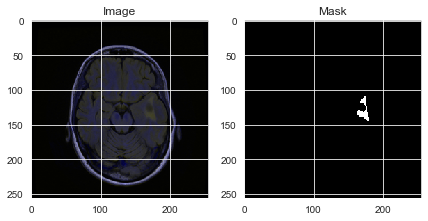

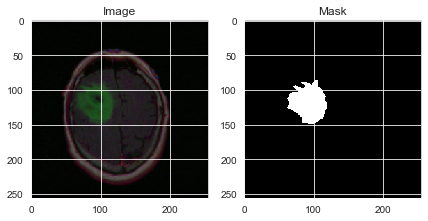

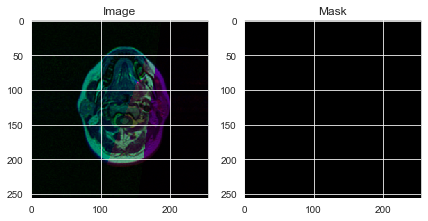

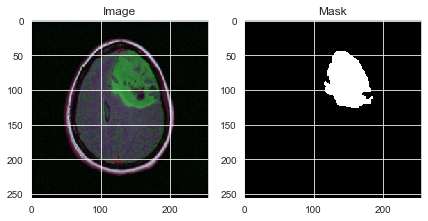

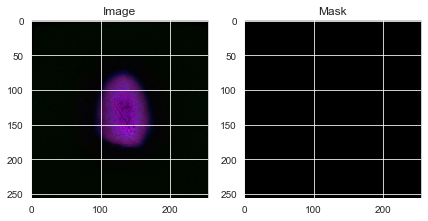

In [42]:
for i in l:
    plot_image(to_plot_one_image(df.iloc[i]["images_paths"]), to_plot_one_image(df.iloc[i]["masks_paths"]))

In [43]:
def create_gens(df, aug_dict):
    img_size = (256, 256)
    batch_size = 40
    img_gen = ImageDataGenerator(**aug_dict)
    msk_gen = ImageDataGenerator(**aug_dict)
    image_gen = img_gen.flow_from_dataframe(df, x_col='images_paths', class_mode=None, color_mode='rgb', target_size=img_size,
                                            batch_size=batch_size, save_to_dir=None, save_prefix='image', seed=1)

    mask_gen = msk_gen.flow_from_dataframe(df, x_col='masks_paths', class_mode=None, color_mode='grayscale', target_size=img_size,
                                            batch_size=batch_size, save_to_dir=None, save_prefix= 'mask', seed=1)

    gen = zip(image_gen, mask_gen)
    for (img, msk) in gen:
        img = img / 255
        msk = msk / 255
        msk[msk > 0.5] = 1
        msk[msk <= 0.5] = 0

        yield (img, msk)

In [44]:
tr_aug_dict = dict(rotation_range=0.2,
                            width_shift_range=0.05,
                            height_shift_range=0.05,
                            shear_range=0.05,
                            zoom_range=0.05,
                            horizontal_flip=True,
                            fill_mode='nearest')

In [45]:
train_gen = create_gens(train_brain_tumor_df, aug_dict=tr_aug_dict)

In [46]:
valid_gen = create_gens(valid_brain_tumor_df, aug_dict={})

In [47]:
test_gen = create_gens(test_brain_tumor_df, aug_dict={})

In [48]:
def show_images(images, masks):
    plt.figure(figsize=(12, 12))
    for i in range(25):
        plt.subplot(5, 5, i+1)
        img_path = images[i]
        mask_path = masks[i]
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(mask_path)
        plt.imshow(image)
        plt.imshow(mask, alpha=0.4)

        plt.axis('off')

    plt.tight_layout()
    plt.show()

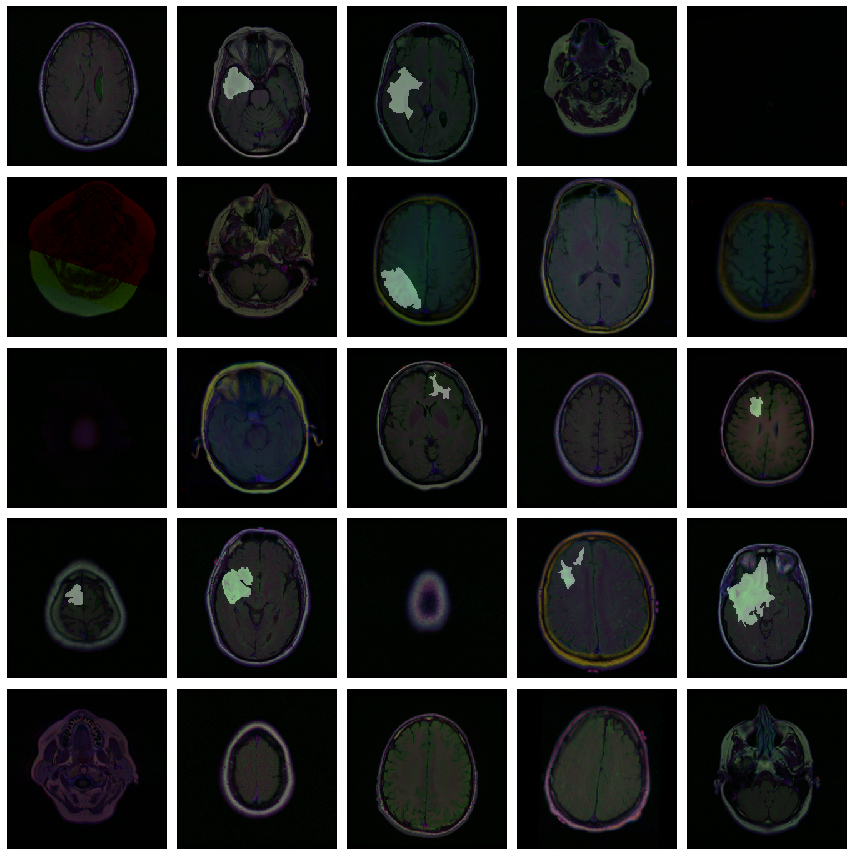

In [49]:
show_images(list(train_brain_tumor_df['images_paths']), list(train_brain_tumor_df['masks_paths']))

In [50]:
def dice_coef(y_true, y_pred, smooth=100):
    y_true_flatten = K.flatten(y_true)
    y_pred_flatten = K.flatten(y_pred)

    intersection = K.sum(y_true_flatten * y_pred_flatten)
    union = K.sum(y_true_flatten) + K.sum(y_pred_flatten)
    return (2 * intersection + smooth) / (union + smooth)

In [51]:
def dice_loss(y_true, y_pred, smooth=100):
    return -dice_coef(y_true, y_pred, smooth)

In [52]:
def iou_coef(y_true, y_pred, smooth=100):
    intersection = K.sum(y_true * y_pred)
    sum = K.sum(y_true + y_pred)
    iou = (intersection + smooth) / (sum - intersection + smooth)
    return iou

In [53]:
def create_contrastive_representation_transfer_learning_model(input_size=(256, 256, 3)):
    inputs = Input(input_size)
    conv1 = Conv2D(filters=64, kernel_size=(3, 3), padding="same")(inputs)
    bn1 = Activation("relu")(conv1)
    conv1 = Conv2D(filters=64, kernel_size=(3, 3), padding="same")(bn1)
    bn1 = BatchNormalization(axis=3)(conv1)
    bn1 = Activation("relu")(bn1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(bn1)

    conv2 = Conv2D(filters=128, kernel_size=(3, 3), padding="same")(pool1)
    bn2 = Activation("relu")(conv2)
    conv2 = Conv2D(filters=128, kernel_size=(3, 3), padding="same")(bn2)
    bn2 = BatchNormalization(axis=3)(conv2)
    bn2 = Activation("relu")(bn2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(bn2)

    conv3 = Conv2D(filters=256, kernel_size=(3, 3), padding="same")(pool2)
    bn3 = Activation("relu")(conv3)
    conv3 = Conv2D(filters=256, kernel_size=(3, 3), padding="same")(bn3)
    bn3 = BatchNormalization(axis=3)(conv3)
    bn3 = Activation("relu")(bn3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(bn3)

    conv4 = Conv2D(filters=512, kernel_size=(3, 3), padding="same")(pool3)
    bn4 = Activation("relu")(conv4)
    conv4 = Conv2D(filters=512, kernel_size=(3, 3), padding="same")(bn4)
    bn4 = BatchNormalization(axis=3)(conv4)
    bn4 = Activation("relu")(bn4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(bn4)

    conv5 = Conv2D(filters=1024, kernel_size=(3, 3), padding="same")(pool4)
    bn5 = Activation("relu")(conv5)
    conv5 = Conv2D(filters=1024, kernel_size=(3, 3), padding="same")(bn5)
    bn5 = BatchNormalization(axis=3)(conv5)
    bn5 = Activation("relu")(bn5)
    up6 = concatenate([Conv2DTranspose(512, kernel_size=(2, 2), strides=(2, 2), padding="same")(bn5), conv4], axis=3)
    conv6 = Conv2D(filters=512, kernel_size=(3, 3), padding="same")(up6)
    bn6 = Activation("relu")(conv6)
    conv6 = Conv2D(filters=512, kernel_size=(3, 3), padding="same")(bn6)
    bn6 = BatchNormalization(axis=3)(conv6)
    bn6 = Activation("relu")(bn6)

    up7 = concatenate([Conv2DTranspose(256, kernel_size=(2, 2), strides=(2, 2), padding="same")(bn6), conv3], axis=3)
    conv7 = Conv2D(filters=256, kernel_size=(3, 3), padding="same")(up7)
    bn7 = Activation("relu")(conv7)
    conv7 = Conv2D(filters=256, kernel_size=(3, 3), padding="same")(bn7)
    bn7 = BatchNormalization(axis=3)(conv7)
    bn7 = Activation("relu")(bn7)

    up8 = concatenate([Conv2DTranspose(128, kernel_size=(2, 2), strides=(2, 2), padding="same")(bn7), conv2], axis=3)
    conv8 = Conv2D(filters=128, kernel_size=(3, 3), padding="same")(up8)
    bn8 = Activation("relu")(conv8)
    conv8 = Conv2D(filters=128, kernel_size=(3, 3), padding="same")(bn8)
    bn8 = BatchNormalization(axis=3)(conv8)
    bn8 = Activation("relu")(bn8)

    up9 = concatenate([Conv2DTranspose(64, kernel_size=(2, 2), strides=(2, 2), padding="same")(bn8), conv1], axis=3)
    conv9 = Conv2D(filters=64, kernel_size=(3, 3), padding="same")(up9)
    bn9 = Activation("relu")(conv9)
    conv9 = Conv2D(filters=64, kernel_size=(3, 3), padding="same")(bn9)
    bn9 = BatchNormalization(axis=3)(conv9)
    bn9 = Activation("relu")(bn9)

    conv10 = Conv2D(filters=1, kernel_size=(1, 1), activation="sigmoid")(bn9)

    return Model(inputs=[inputs], outputs=[conv10])

In [54]:
def show_images(images, masks):
    plt.figure(figsize=(12, 12))
    for i in range(25):
        plt.subplot(5, 5, i+1)
        img_path = images[i]
        mask_path = masks[i]
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(mask_path)
        plt.imshow(image)
        plt.imshow(mask, alpha=0.4)

        plt.axis('off')

    plt.tight_layout()
    plt.show()

In [55]:
def plot_training(hist):
    tr_acc = hist.history['accuracy']
    tr_iou = hist.history['iou_coef']
    tr_dice = hist.history['dice_coef']
    tr_loss = hist.history['loss']

    val_acc = hist.history['val_accuracy']
    val_iou = hist.history['val_iou_coef']
    val_dice = hist.history['val_dice_coef']
    val_loss = hist.history['val_loss']

    index_acc = np.argmax(val_acc)
    acc_highest = val_acc[index_acc]
    index_iou = np.argmax(iou_coef)
    iou_highest = val_iou[index_iou]
    index_dice = np.argmax(dice_coef)
    dice_highest = val_dice[index_dice]
    index_loss = np.argmin(val_loss)
    val_lowest = val_loss[index_loss]

    Epochs = [i+1 for i in range(len(tr_acc))]

    acc_label = f'best epoch= {str(index_acc + 1)}'
    iou_label = f'best epoch= {str(index_iou + 1)}'
    dice_label = f'best epoch= {str(index_dice + 1)}'
    loss_label = f'best epoch= {str(index_loss + 1)}'

    plt.figure(figsize= (20, 20))
    plt.style.use('fivethirtyeight')
    plt.subplot(2, 2, 1)
    plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
    plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
    plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(2, 2, 2)
    plt.plot(Epochs, tr_iou, 'r', label= 'Training IoU')
    plt.plot(Epochs, val_iou, 'g', label= 'Validation IoU')
    plt.scatter(index_iou + 1 , iou_highest, s= 150, c= 'blue', label= iou_label)
    plt.title('Training and Validation IoU Coefficient')
    plt.xlabel('Epochs')
    plt.ylabel('IoU')
    plt.legend()

    # Training Dice
    plt.subplot(2, 2, 3)
    plt.plot(Epochs, tr_dice, 'r', label= 'Training Dice')
    plt.plot(Epochs, val_dice, 'g', label= 'Validation Dice')
    plt.scatter(index_dice + 1 , dice_highest, s= 150, c= 'blue', label= dice_label)
    plt.title('Training and Validation Dice Coefficient')
    plt.xlabel('Epochs')
    plt.ylabel('Dice')
    plt.legend()

    # Training Loss
    plt.subplot(2, 2, 4)
    plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
    plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
    plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout
    plt.show()

In [56]:
model = create_contrastive_representation_transfer_learning_model()

In [57]:
model.compile(Adamax(learning_rate= 0.001), loss= dice_loss, metrics= ['accuracy', iou_coef, dice_coef])

In [58]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 activation (Activation)        (None, 256, 256, 64  0           ['conv2d[0][0]']                 
                                )                                                             

 conv2d_transpose (Conv2DTransp  (None, 32, 32, 512)  2097664    ['activation_9[0][0]']           
 ose)                                                                                             
                                                                                                  
 concatenate (Concatenate)      (None, 32, 32, 1024  0           ['conv2d_transpose[0][0]',       
                                )                                 'conv2d_7[0][0]']               
                                                                                                  
 conv2d_10 (Conv2D)             (None, 32, 32, 512)  4719104     ['concatenate[0][0]']            
                                                                                                  
 activation_10 (Activation)     (None, 32, 32, 512)  0           ['conv2d_10[0][0]']              
                                                                                                  
 conv2d_11

In [59]:
epochs = 30

In [60]:
batch_size = 40

In [61]:
callbacks = [ModelCheckpoint('Brain-Tumor-Segmentation-Model.hdf5', verbose=0, save_best_only=True)]

In [ ]:
history = model.fit(train_gen,
                    steps_per_epoch=len(train_brain_tumor_df) / batch_size,
                    epochs=epochs,
                    verbose=1,
                    callbacks=callbacks,
                    validation_data = valid_gen,
                    validation_steps=len(valid_brain_tumor_df) / batch_size)

Found 1600 validated image filenames.
Found 1600 validated image filenames.
Epoch 1/30


In [ ]:
plot_training(history)

In [ ]:
ts_length = len(test_brain_tumor_df)

In [ ]:
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))

In [ ]:
test_steps = ts_length // test_batch_size

In [ ]:
train_score = model.evaluate(train_gen, steps= test_steps, verbose= 1)

In [ ]:
valid_score = model.evaluate(valid_gen, steps= test_steps, verbose= 1)

In [ ]:
test_score = model.evaluate(test_gen, steps= test_steps, verbose= 1)

In [ ]:
print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print("Train IoU: ", train_score[2])
print("Train Dice: ", train_score[3])
print('-' * 20)

print("Valid Loss: ", valid_score[0])
print("Valid Accuracy: ", valid_score[1])
print("Valid IoU: ", valid_score[2])
print("Valid Dice: ", valid_score[3])
print('-' * 20)

print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])
print("Test IoU: ", test_score[2])
print("Test Dice: ", test_score[3])

In [ ]:
for _ in range(20):
    index = np.random.randint(1, len(test_brain_tumor_df.index))
    img = cv2.imread(test_brain_tumor_df['images_paths'].iloc[index])
    img = cv2.resize(img, (256, 256))
    img = img/255
    img = img[np.newaxis, :, :, : ]

    predicted_img = model.predict(img)

    plt.figure(figsize=(12, 12))
    
    plt.subplot(1, 3, 1)
    plt.imshow(np.squeeze(img))
    plt.axis('off')
    plt.title('Original Image')

    plt.subplot(1, 3, 2)
    plt.imshow(np.squeeze(cv2.imread(test_brain_tumor_df['masks_paths'].iloc[index])))
    plt.axis('off')
    plt.title('Original Mask')

    plt.subplot(1, 3, 3)
    plt.imshow(np.squeeze(predicted_img) > 0.5 )
    plt.title('Prediction')
    plt.axis('off')
    
    plt.show()

In [ ]:
import sys

print(sys.version)